In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Paths
FAULT_DIR = "/kaggle/input/processed-seiemic-data/normalized_fault"
SEIS_DIR = "/kaggle/input/processed-seiemic-data/normalized_seis"
VISUAL_DIR = "/kaggle/working/visual"  # Folder to store predictions
IMG_SIZE = 128  # Image size

# Create visual folder
os.makedirs(VISUAL_DIR, exist_ok=True)

# Load Seismic Images
def load_seismic_images(seis_dir):
    seis_images = []
    seis_files = sorted(os.listdir(seis_dir))  # Ensure consistent order

    for file in seis_files:
        seis_path = os.path.join(seis_dir, file)
        seis_img = img_to_array(load_img(seis_path, color_mode='grayscale', target_size=(IMG_SIZE, IMG_SIZE))) / 255.0
        seis_images.append(seis_img)
    
    return np.array(seis_images), seis_files

# Load Fault Images
def load_fault_images(fault_dir):
    fault_images = []
    fault_files = sorted(os.listdir(fault_dir))  # Ensure consistent order

    for file in fault_files:
        fault_path = os.path.join(fault_dir, file)
        fault_img = img_to_array(load_img(fault_path, color_mode='grayscale', target_size=(IMG_SIZE, IMG_SIZE))) / 255.0
        fault_images.append(fault_img)
    
    return np.array(fault_images)

# Load dataset
X, seis_filenames = load_seismic_images(SEIS_DIR)
Y = load_fault_images(FAULT_DIR)

# Ensure correct shape for training
X = np.expand_dims(X, axis=-1)  # Shape: (N, IMG_SIZE, IMG_SIZE, 1)
Y = np.expand_dims(Y, axis=-1)  # Shape: (N, IMG_SIZE, IMG_SIZE, 1)

# Train-test split (80-20)
X_train, X_test, Y_train, Y_test, train_files, test_files = train_test_split(X, Y, seis_filenames, test_size=0.2, random_state=42)

print(f"Training Seismic Shape: {X_train.shape}, Fault Shape: {Y_train.shape}")
print(f"Testing Seismic Shape: {X_test.shape}, Fault Shape: {Y_test.shape}")

# U-Net Model
def unet_model(input_size=(IMG_SIZE, IMG_SIZE, 1)):
    inputs = Input(input_size)
    
    # Encoder
    c1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D(pool_size=(2, 2))(c1)
    
    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D(pool_size=(2, 2))(c2)
    
    c3 = Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D(pool_size=(2, 2))(c3)
    
    # Bottleneck
    c4 = Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = Conv2D(512, 3, activation='relu', padding='same')(c4)
    
    # Decoder
    u1 = UpSampling2D(size=(2, 2))(c4)
    u1 = concatenate([u1, c3])
    c5 = Conv2D(256, 3, activation='relu', padding='same')(u1)
    c5 = Conv2D(256, 3, activation='relu', padding='same')(c5)
    
    u2 = UpSampling2D(size=(2, 2))(c5)
    u2 = concatenate([u2, c2])
    c6 = Conv2D(128, 3, activation='relu', padding='same')(u2)
    c6 = Conv2D(128, 3, activation='relu', padding='same')(c6)
    
    u3 = UpSampling2D(size=(2, 2))(c6)
    u3 = concatenate([u3, c1])
    c7 = Conv2D(64, 3, activation='relu', padding='same')(u3)
    c7 = Conv2D(64, 3, activation='relu', padding='same')(c7)
    
    outputs = Conv2D(1, 1, activation='sigmoid', padding='same')(c7)  # Sigmoid activation for segmentation
    
    return Model(inputs, outputs)

# Compile & Train
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, Y_train, epochs=30, batch_size=8, validation_split=0.2)

# Save model
model.save("unet_fault_segmentation.h5")
print("Training Complete. Model Saved!")

# Predict on Test Set
Y_pred = model.predict(X_test)


Training Seismic Shape: (20480, 128, 128, 1, 1), Fault Shape: (20480, 128, 128, 1, 1)
Testing Seismic Shape: (5120, 128, 128, 1, 1), Fault Shape: (5120, 128, 128, 1, 1)
Epoch 1/30
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 223s 99ms/step - accuracy: 0.9193 - loss: 0.1871 - val_accuracy: 0.9165 - val_loss: 0.1084
Epoch 2/30
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 205s 100ms/step - accuracy: 0.9184 - loss: 0.1038 - val_accuracy: 0.9173 - val_loss: 0.0943
Epoch 3/30
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 206s 101ms/step - accuracy: 0.9187 - loss: 0.0909 - val_accuracy: 0.9179 - val_loss: 0.0877
Epoch 4/30
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 206s 101ms/step - accuracy: 0.9186 - loss: 0.0843 - val_accuracy: 0.9188 - val_loss: 0.0867
Epoch 5/30
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 206s 100ms/step - accuracy: 0.9193 - loss: 0.0796 - val_accuracy: 0.9189 - val_loss: 0.0832
Epoch 6/30
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 206s 100ms/step - accuracy: 0.9192 - loss: 0.0762 - val_accuracy: 0.9171 - val_loss: 0.0810
Epoch 7/30
2048/2048 ━━━━━━━

In [2]:
# Save predictions in the 'visual' folder
for i in range(len(X_test)):
    pred_img = array_to_img(Y_pred[i])  # Convert numpy array to image
    pred_img.save(os.path.join(VISUAL_DIR, f"pred_{test_files[i]}"))  # Save with same name

print("Predictions saved in 'visual' folder.")

Predictions saved in 'visual' folder.


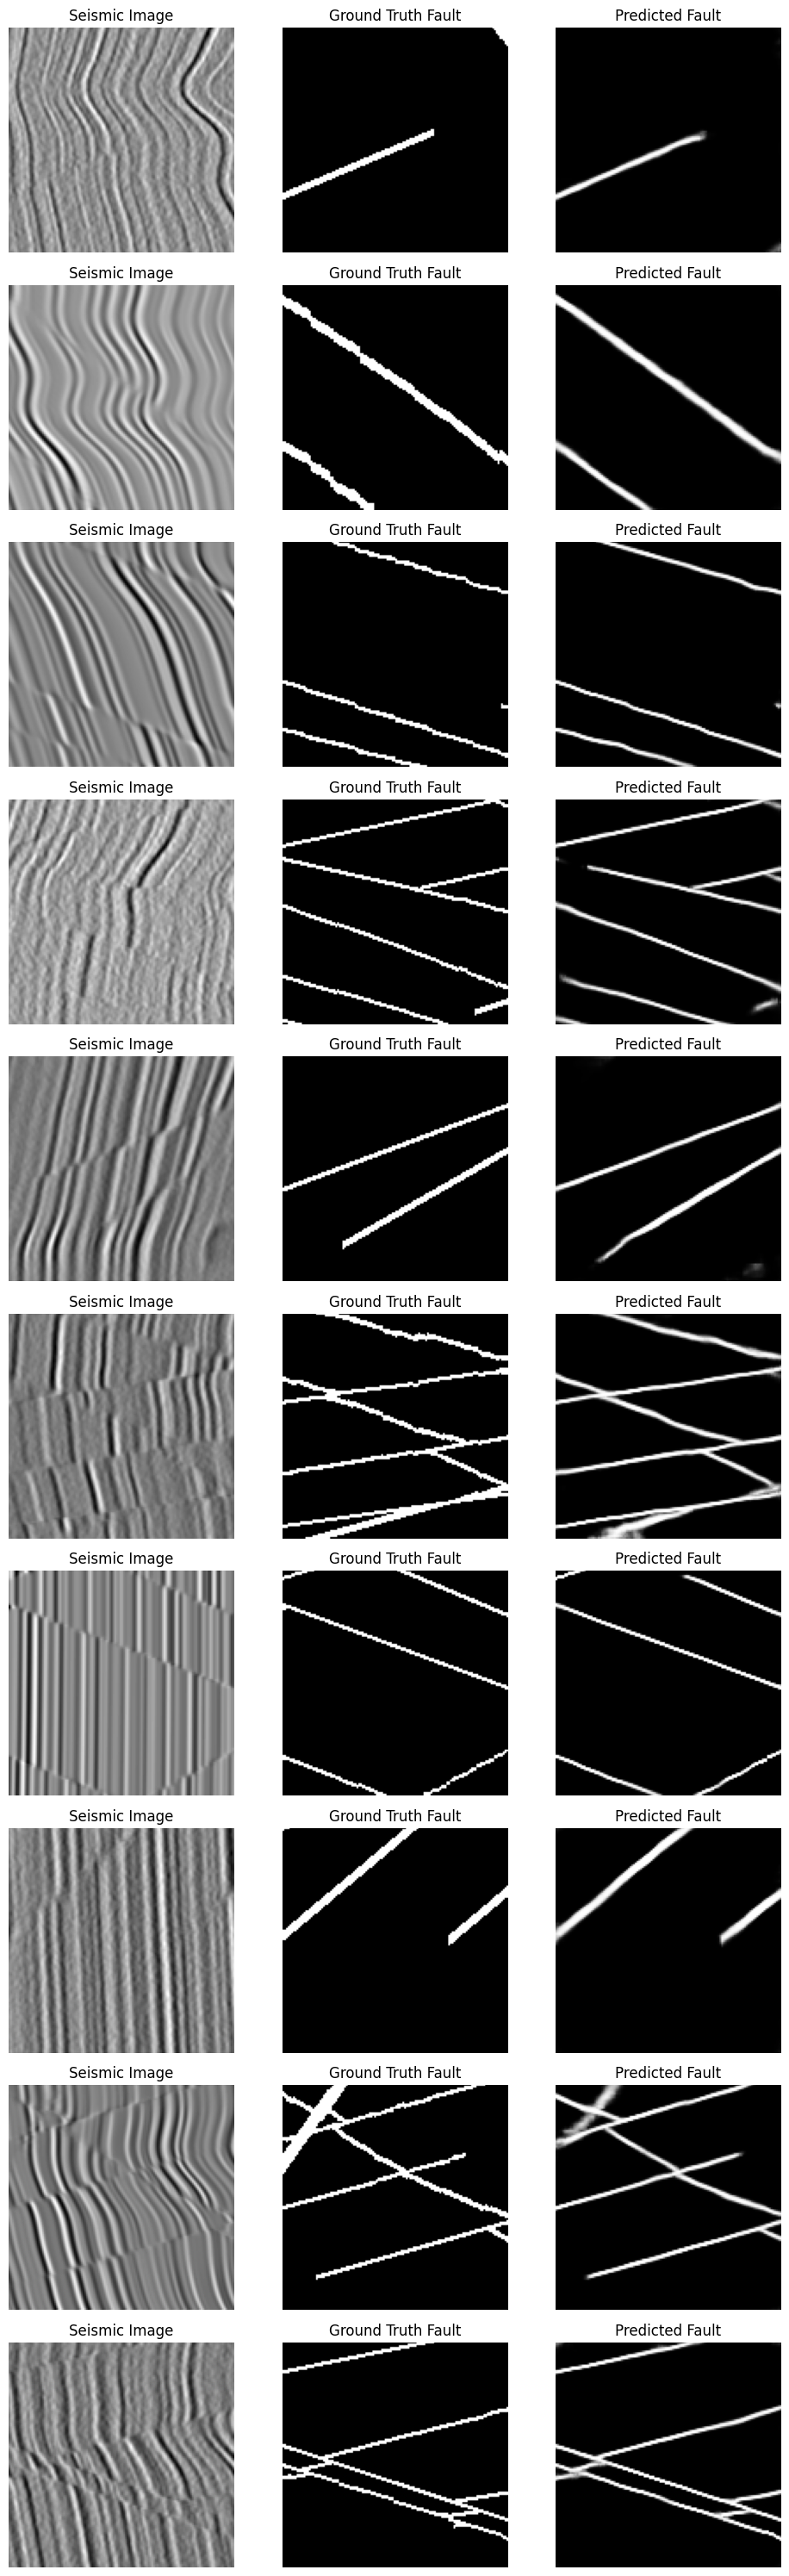

In [3]:

# Display 10 Predictions
fig, axes = plt.subplots(10, 3, figsize=(10, 30))  # 10 rows, 3 columns

for i in range(10):
    # Seismic Image
    axes[i, 0].imshow(X_test[i].squeeze(), cmap='gray')
    axes[i, 0].set_title("Seismic Image")
    axes[i, 0].axis('off')

    # Ground Truth
    axes[i, 1].imshow(Y_test[i].squeeze(), cmap='gray')
    axes[i, 1].set_title("Ground Truth Fault")
    axes[i, 1].axis('off')

    # Prediction
    axes[i, 2].imshow(Y_pred[i].squeeze(), cmap='gray')
    axes[i, 2].set_title("Predicted Fault")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()


In [4]:

# Zip the visual folder for download
shutil.make_archive("/kaggle/working/visual_predictions", 'zip', VISUAL_DIR)
print("Download the 'visual_predictions.zip' file containing fault predictions.")


Download the 'visual_predictions.zip' file containing fault predictions.
